In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import SIR, D4J, load_test_suite

In [2]:
path = '../data/results-2026-01-17-165719/results.csv'

# df = pd.read_csv('../data/results-2026-01-08-190113.csv', index_col=0)
df_raw = pd.read_csv(path, index_col=None)

df = df_raw.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27500 entries, 0 to 27499
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_faults           27500 non-null  int64  
 1   faults_detected        27500 non-null  int64  
 2   preperation_time_ns    27500 non-null  int64  
 3   reduction_time_ns      27500 non-null  int64  
 4   fft                    27500 non-null  int64  
 5   tsr                    27500 non-null  float64
 6   fdl                    27500 non-null  float64
 7   apfd                   27500 non-null  float64
 8   timestamp_utc          27500 non-null  object 
 9   test_suite             27500 non-null  object 
 10  program                27500 non-null  object 
 11  version                27500 non-null  object 
 12  language               27500 non-null  object 
 13  n_total_tests          27500 non-null  int64  
 14  budget_prop_requested  27500 non-null  float64
 15  n_

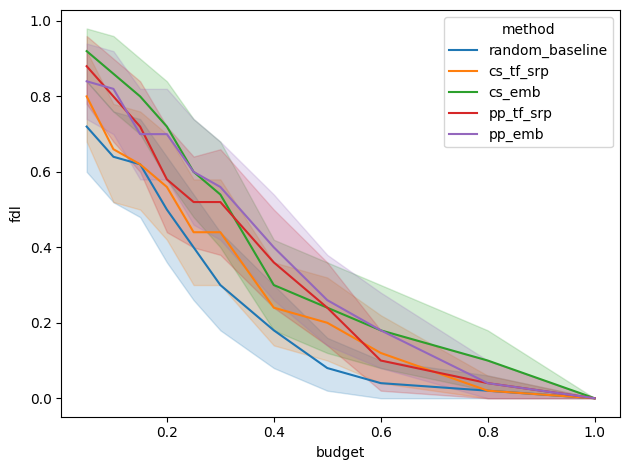

In [3]:
ax = sns.lineplot(
    data=df[df['test_suite'] == 'closure_v1'],
    x="budget_prop_requested",
    y="fdl",
    hue="method",
    estimator="mean",
    errorbar=("ci", 95),   # bootstrap CI by default
    n_boot=1000,           # increase for smoother CI
)

ax.set(xlabel="budget", ylabel="fdl")
# plt.yscale('log')
plt.tight_layout()
plt.show()

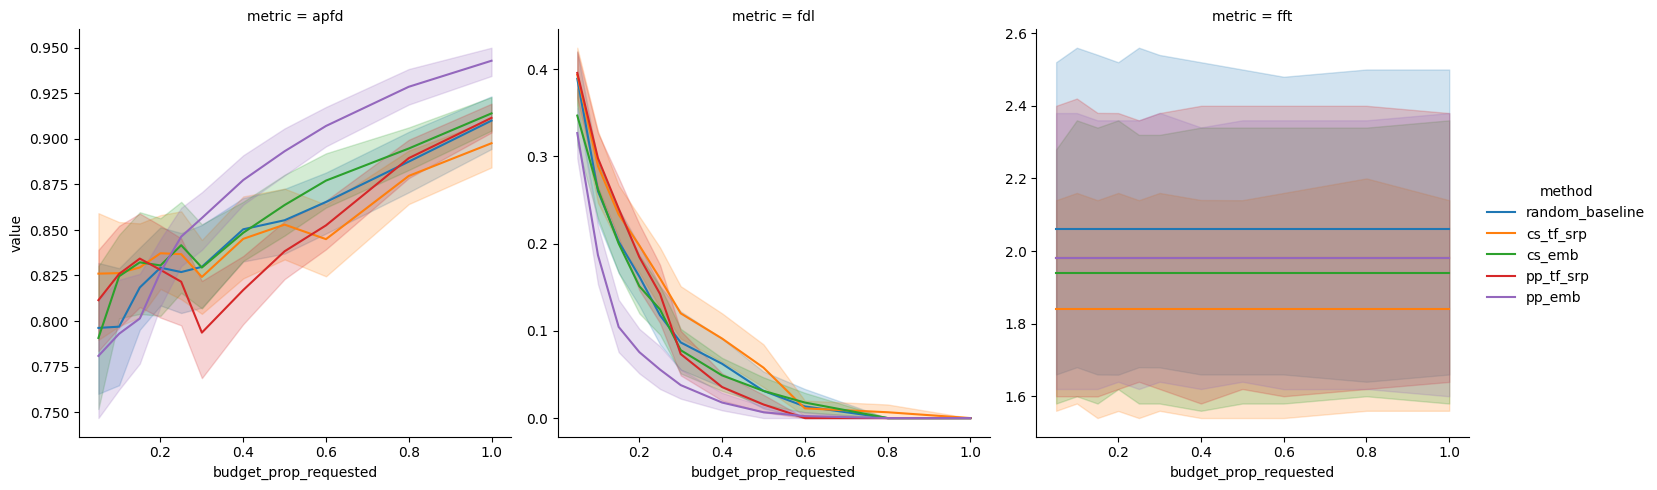

In [4]:
dataset = 'flex_v3'

df_base = df[df['test_suite'] == dataset]

metrics = ["apfd", "fdl", "fft"]  # your y-columns

df_long = df_base.melt(
    id_vars=["method", "budget_prop_requested"],      # add replicate id here too if you have one, e.g. ["algo","tsr","rep"]
    value_vars=metrics,
    var_name="metric",
    value_name="value",
)

g = sns.relplot(
    data=df_long,
    x="budget_prop_requested", y="value",
    hue="method",
    col="metric",
    col_wrap=3,                  # layout
    kind="line",
    estimator="mean",
    errorbar=("ci", 95),         # seaborn >= 0.12 (use ci=95 for 0.11.x)
    n_boot=1000,
    facet_kws={"sharey": False}  # different scales per metric
)

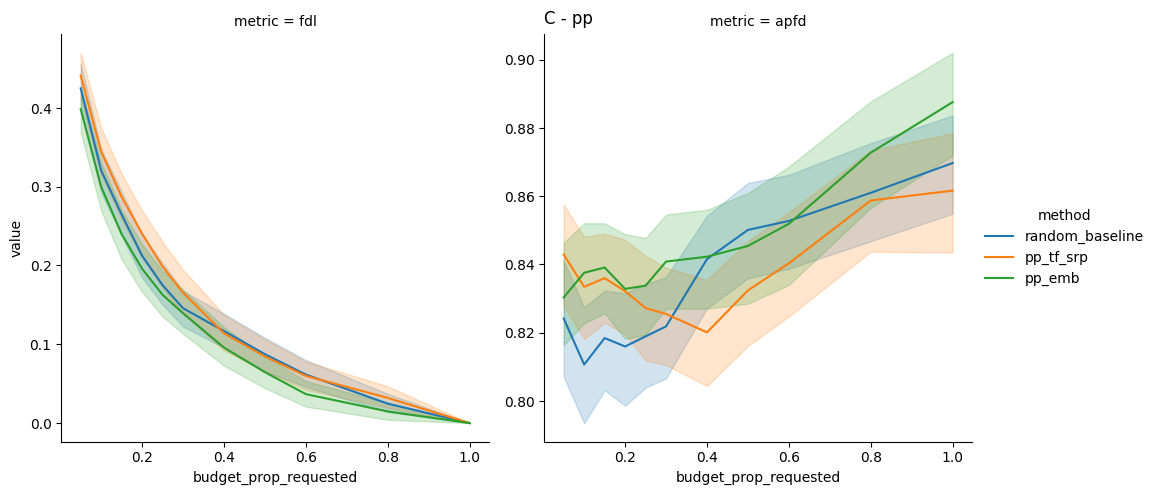

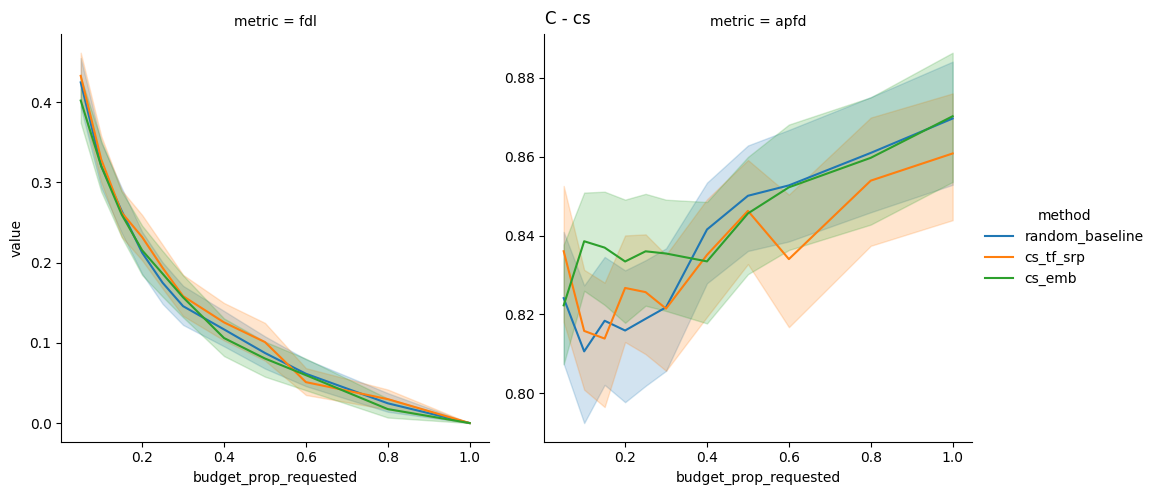

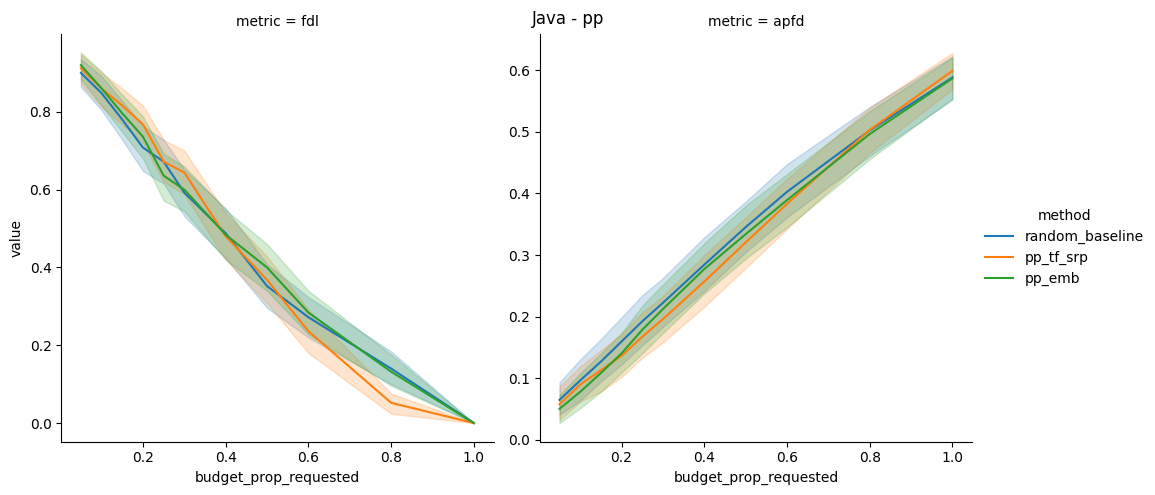

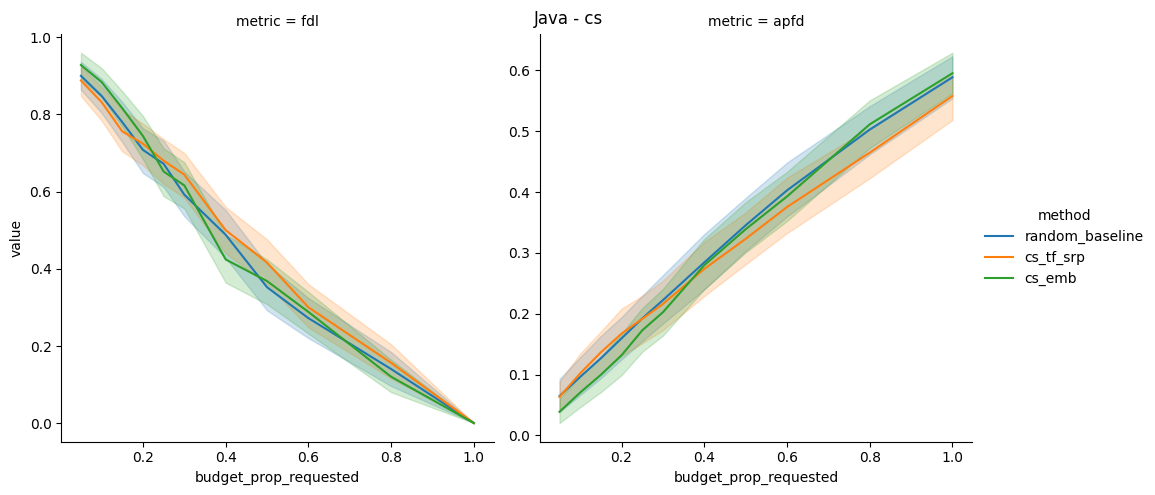

In [12]:
def plot_metrics_by_budget(df, lang, algo_base):
    df_base = df[df['language'] == lang]
    df_base = df_base[(df_base['method'].str.startswith(algo_base)) | (df_base['method'].str.startswith("random"))]

    metrics = ["fdl", "apfd"]  # your y-columns "apfd"

    df_long = df_base.melt(
        id_vars=["method", "budget_prop_requested"],      # add replicate id here too if you have one, e.g. ["algo","tsr","rep"]
        value_vars=metrics,
        var_name="metric",
        value_name="value",
    )

    g = sns.relplot(
        data=df_long,
        x="budget_prop_requested", y="value",
        hue="method",
        col="metric",
        col_wrap=len(metrics),                  # layout
        kind="line",
        estimator="mean",
        errorbar=("ci", 95),         # seaborn >= 0.12 (use ci=95 for 0.11.x)
        n_boot=1000,
        facet_kws={"sharey": False}  # different scales per metric
    )

    return g


for lang in df['language'].unique():
    for algo_base in ['pp', 'cs']:
        ax = plot_metrics_by_budget(df, lang, algo_base)
        
        plt.suptitle(f'{lang} - {algo_base}')

        ax.savefig(f'../data/plots/{lang}_{algo_base}.png')

        plt.show()

In [37]:
from scipy.stats import kruskal, wilcoxon, friedmanchisquare


df = df_raw[df_raw['language'] == "C"].copy()

pivot_df_C = df.pivot(columns='method', index=['run_id', 'budget_prop_requested', 'program'], values='fdl').reset_index().sort_values('budget_prop_requested')

friedmanchisquare(pivot_df_C["cs_emb"], pivot_df_C["cs_tf_srp"], pivot_df_C['pp_emb'], pivot_df_C['pp_tf_srp'])

FriedmanchisquareResult(statistic=np.float64(170.60832075878082), pvalue=np.float64(9.404540530053637e-37))

In [38]:
df = df_raw[df_raw['language'] == "Java"].copy()

pivot_df_java = df.pivot(columns='method', index=['run_id', 'budget_prop_requested', 'program'], values='fdl').reset_index().sort_values('budget_prop_requested')

friedmanchisquare(pivot_df_java["cs_emb"], pivot_df_java["cs_tf_srp"], pivot_df_java['pp_emb'], pivot_df_java['pp_tf_srp'])

FriedmanchisquareResult(statistic=np.float64(0.5954381752807759), pvalue=np.float64(0.8974759003345546))

In [8]:
methods = df['method'].unique()

for i, method1 in enumerate(methods):
    for j, method2 in enumerate(methods):
        if i == j:
            continue
        print(f"{method1} - {method2}")
        print(wilcoxon(pivot_df_C[method1], pivot_df_C[method2], alternative='less'))

random_baseline - cs_tf_srp
WilcoxonResult(statistic=np.float64(443575.0), pvalue=np.float64(0.2063748554538331))
random_baseline - cs_emb
WilcoxonResult(statistic=np.float64(468457.5), pvalue=np.float64(0.9997918009373249))
random_baseline - pp_tf_srp
WilcoxonResult(statistic=np.float64(377491.0), pvalue=np.float64(0.04761524502493617))
random_baseline - pp_emb
WilcoxonResult(statistic=np.float64(505264.5), pvalue=np.float64(0.9999999999999966))
cs_tf_srp - random_baseline
WilcoxonResult(statistic=np.float64(467000.0), pvalue=np.float64(0.7936251445461668))
cs_tf_srp - cs_emb
WilcoxonResult(statistic=np.float64(477979.5), pvalue=np.float64(0.9999956945058971))
cs_tf_srp - pp_tf_srp
WilcoxonResult(statistic=np.float64(313872.5), pvalue=np.float64(0.22146410959255575))
cs_tf_srp - pp_emb
WilcoxonResult(statistic=np.float64(514811.5), pvalue=np.float64(1.0))
cs_emb - random_baseline
WilcoxonResult(statistic=np.float64(373295.5), pvalue=np.float64(0.0002081990626750931))
cs_emb - cs_tf_sr

In [27]:
import itertools
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# methods present as columns in pivot_df_C (recommended)
methods = df['method'].unique()

rows = []
for m1, m2 in itertools.combinations(methods, 2):
    x = pivot_df_C[m1]
    y = pivot_df_C[m2]

    # Wilcoxon needs paired, non-missing observations
    mask = x.notna() & y.notna()
    x2, y2 = x[mask], y[mask]

    if len(x2) == 0:
        continue

    # Compute p-values (two-sided + directional)
    two = wilcoxon(x2, y2, alternative="two-sided")
    less = wilcoxon(x2, y2, alternative="less")
    greater = wilcoxon(x2, y2, alternative="greater")

    diff = x2 - y2
    rows.append({
        "method1": m1,
        "method2": m2,
        "n_pairs": int(mask.sum()),
        "statistic": float(two.statistic),
        "p_two_sided": float(two.pvalue),
        "p_less_(m1<m2)": float(less.pvalue),
        "p_greater_(m1>m2)": float(greater.pvalue),
        "median_diff_(m1-m2)": float(diff.median()),
        "mean_diff_(m1-m2)": float(diff.mean()),
    })

results = pd.DataFrame(rows)

# Multiple-testing correction (choose which p-column you want to adjust)
# Example: adjust two-sided p-values with Holm (common for post-hoc)
results["p_two_sided_holm"] = multipletests(results["p_two_sided"], method="holm")[1]

# Optional: also adjust the directional p-values (if you plan to interpret them)
results["p_less_holm"] = multipletests(results["p_less_(m1<m2)"], method="holm")[1]
results["p_greater_holm"] = multipletests(results["p_greater_(m1>m2)"], method="holm")[1]

# ---- Table 1 (long form): one row per pair
results = results.sort_values(["p_two_sided_holm", "p_two_sided"]).reset_index(drop=True)
print(results)

# ---- Table 2 (matrix form): symmetric matrix of adjusted p-values (two-sided Holm)
p_mat = pd.DataFrame(index=methods, columns=methods, dtype=float)
for _, r in results.iterrows():
    p_mat.loc[r["method1"], r["method2"]] = r["p_two_sided_holm"]
    p_mat.loc[r["method2"], r["method1"]] = r["p_two_sided_holm"]
np.fill_diagonal(p_mat.values, np.nan)

print(p_mat)

           method1    method2  n_pairs  statistic   p_two_sided  \
0        pp_tf_srp     pp_emb     2750   229317.5  1.650344e-22   
1        cs_tf_srp     pp_emb     2750   284668.5  7.210457e-19   
2  random_baseline     pp_emb     2750   301820.5  6.901433e-15   
3           cs_emb     pp_emb     2750   298280.5  7.160585e-08   
4           cs_emb  pp_tf_srp     2750   355029.0  8.341233e-07   
5        cs_tf_srp     cs_emb     2750   358591.5  8.610988e-06   
6  random_baseline     cs_emb     2750   373295.5  4.163981e-04   
7  random_baseline  pp_tf_srp     2750   377491.0  9.523049e-02   
8  random_baseline  cs_tf_srp     2750   443575.0  4.127497e-01   
9        cs_tf_srp  pp_tf_srp     2750   313872.5  4.429282e-01   

   p_less_(m1<m2)  p_greater_(m1>m2)  median_diff_(m1-m2)  mean_diff_(m1-m2)  \
0    1.000000e+00       8.251718e-23                  0.0           0.028991   
1    1.000000e+00       3.605228e-19                  0.0           0.024305   
2    1.000000e+00     

In [29]:
# Select and rename columns for LaTeX clarity
latex_df = results[[
    "method1",
    "method2",
    "n_pairs",
    "statistic",
    "median_diff_(m1-m2)",
    "p_two_sided",
    "p_two_sided_holm",
]].rename(columns={
    "method1": "Method 1",
    "method2": "Method 2",
    "n_pairs": "$n$",
    "statistic": "Wilcoxon $W$",
    "median_diff_(m1-m2)": "Median Diff",
    "p_two_sided": "$p$ (two-sided)",
    "p_two_sided_holm": "$p$ (Holm)"
})

# Optional: round for presentation
latex_df = latex_df.round({
    "Wilcoxon $W$": 3,
    "Median Diff": 4,
    "$p$ (two-sided)": 4,
    "$p$ (Holm)": 4
})

# Export to LaTeX
latex_table = latex_df.to_latex(
    index=False,
    escape=False,      # allows math symbols
    column_format="llrcccc",
    caption="Pairwise Wilcoxon signed-rank tests following a significant Friedman test.",
    label="tab:wilcoxon_posthoc"
)

print(latex_table)

\begin{table}
\caption{Pairwise Wilcoxon signed-rank tests following a significant Friedman test.}
\label{tab:wilcoxon_posthoc}
\begin{tabular}{llrcccc}
\toprule
Method 1 & Method 2 & $n$ & Wilcoxon $W$ & Median Diff & $p$ (two-sided) & $p$ (Holm) \\
\midrule
pp_tf_srp & pp_emb & 2750 & 229317.500000 & 0.000000 & 0.000000 & 0.000000 \\
cs_tf_srp & pp_emb & 2750 & 284668.500000 & 0.000000 & 0.000000 & 0.000000 \\
random_baseline & pp_emb & 2750 & 301820.500000 & 0.000000 & 0.000000 & 0.000000 \\
cs_emb & pp_emb & 2750 & 298280.500000 & 0.000000 & 0.000000 & 0.000000 \\
cs_emb & pp_tf_srp & 2750 & 355029.000000 & 0.000000 & 0.000000 & 0.000000 \\
cs_tf_srp & cs_emb & 2750 & 358591.500000 & 0.000000 & 0.000000 & 0.000000 \\
random_baseline & cs_emb & 2750 & 373295.500000 & 0.000000 & 0.000400 & 0.001700 \\
random_baseline & pp_tf_srp & 2750 & 377491.000000 & 0.000000 & 0.095200 & 0.285700 \\
random_baseline & cs_tf_srp & 2750 & 443575.000000 & 0.000000 & 0.412700 & 0.825500 \\
cs_tf_srp &

In [35]:
import itertools
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

alpha = 0.05
mt_method = "fdr_bh"   # or "fdr_bh", "bonferroni", ...

methods = df['method'].unique()

pivot_df = pivot_df_C[methods].copy()

# ---------- 1) Pairwise Wilcoxon + multiplicity correction ----------
pairs, pvals, stats, ns = [], [], [], []
for m1, m2 in itertools.combinations(methods, 2):
    x, y = pivot_df[m1], pivot_df[m2]
    mask = x.notna() & y.notna()
    x2, y2 = x[mask], y[mask]
    if len(x2) == 0:
        continue

    res = wilcoxon(x2, y2, alternative="two-sided")
    pairs.append((m1, m2))
    pvals.append(res.pvalue)
    stats.append(res.statistic)
    ns.append(int(mask.sum()))

p_adj = multipletests(pvals, method=mt_method)[1]

pairwise = pd.DataFrame({
    "method1": [a for a, b in pairs],
    "method2": [b for a, b in pairs],
    "n_pairs": ns,
    "W": stats,
    "p": pvals,
    "p_adj": p_adj,
})

# Build a symmetric "significant difference" matrix: True means significantly different
sig = pd.DataFrame(False, index=methods, columns=methods)
for _, r in pairwise.iterrows():
    a, b = r["method1"], r["method2"]
    s = bool(r["p_adj"] < alpha)
    sig.loc[a, b] = s
    sig.loc[b, a] = s
np.fill_diagonal(sig.values, False)

# ---------- 2) Compact Letter Display (CLD) grouping ----------
# Methods that share a letter are NOT significantly different (per the pairwise matrix).
# This is a standard “grouping letters” summary; it’s greedy (common in practice).
med = pivot_df.median(axis=0, skipna=True).sort_values(ascending=False)
ordered = med.index.tolist()

letters_used = []               # list of letter strings
assign = {m: [] for m in methods}  # method -> list of letters

def conflicts(m, letter):
    """Would assigning 'letter' to method m conflict with any already having that letter?"""
    for other in methods:
        if other == m:
            continue
        if letter in assign[other] and sig.loc[m, other]:
            return True
    return False

for m in ordered:
    placed = False
    for letter in letters_used:
        if not conflicts(m, letter):
            assign[m].append(letter)
            placed = True
    if not placed:
        # create a new letter
        new_letter = chr(ord("a") + len(letters_used))
        letters_used.append(new_letter)
        assign[m].append(new_letter)

grouping = pd.DataFrame({
    "Method": ordered,
    "Median": med.loc[ordered].values,
    "Group": ["".join(assign[m]) for m in ordered],
})

# ---------- 3) LaTeX table for the groupings ----------
grouping_latex = grouping.round({"Median": 4}).to_latex(
    index=False,
    escape=False,
    column_format="lrl",
    caption=(
        f"Compact letter display (CLD) from pairwise Wilcoxon tests "
        f"with {mt_method} correction ($\\alpha={alpha}$). "
        "Methods sharing a letter are not significantly different."
    ),
    label="tab:cld_wilcoxon"
)

print(grouping_latex)

# (Optional) also export the pairwise table to LaTeX:
pairwise_latex = pairwise.sort_values("p_adj").round({"W": 3, "p": 6, "p_adj": 6}).to_latex(
    index=False,
    escape=False,
    caption=f"Pairwise Wilcoxon signed-rank tests with {mt_method} correction.",
    label="tab:pairwise_wilcoxon"
)
print(pairwise_latex)


\begin{table}
\caption{Compact letter display (CLD) from pairwise Wilcoxon tests with fdr_bh correction ($\alpha=0.05$). Methods sharing a letter are not significantly different.}
\label{tab:cld_wilcoxon}
\begin{tabular}{lrl}
\toprule
Method & Median & Group \\
\midrule
cs_tf_srp & 0.111100 & a \\
random_baseline & 0.000000 & a \\
cs_emb & 0.000000 & b \\
pp_tf_srp & 0.000000 & a \\
pp_emb & 0.000000 & c \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Pairwise Wilcoxon signed-rank tests with fdr_bh correction.}
\label{tab:pairwise_wilcoxon}
\begin{tabular}{llrrrr}
\toprule
method1 & method2 & n_pairs & W & p & p_adj \\
\midrule
pp_tf_srp & pp_emb & 2750 & 229317.500000 & 0.000000 & 0.000000 \\
cs_tf_srp & pp_emb & 2750 & 284668.500000 & 0.000000 & 0.000000 \\
random_baseline & pp_emb & 2750 & 301820.500000 & 0.000000 & 0.000000 \\
cs_emb & pp_emb & 2750 & 298280.500000 & 0.000000 & 0.000000 \\
cs_emb & pp_tf_srp & 2750 & 355029.000000 & 0.000001 & 0.000002 \\
cs_tf_srp

In [19]:
def plot_by_algorithm_family_and_language(df, agg_fn: str = "mean"):
    df = df.copy()
    df['budget'] = df['budget_prop_requested']

    fig, ax = plt.subplots(2, 3, figsize = (20, 10), sharex=True, sharey=False)

    sns.lineplot(
        data=df[(df['algorithm_family'] != 'pp') & (df['language'] == 'C')],
        x="budget",
        y="fdl",
        hue="method",
        estimator=agg_fn,
        errorbar=("ci", 95),   # bootstrap CI by default
        n_boot=1000,           # increase for smoother CI
        ax = ax[0, 0]
    )

    sns.lineplot(
        data=df[(df['algorithm_family'] != 'cs') & (df['language'] == 'C')],
        x="budget",
        y="fdl",
        hue="method",
        estimator=agg_fn,
        errorbar=("ci", 95),   # bootstrap CI by default
        n_boot=1000,           # increase for smoother CI
        ax = ax[0, 1]
    )

    sns.lineplot(
        data=df[(df['language'] == 'C')],
        x="budget",
        y="fdl",
        hue="method",
        estimator=agg_fn,
        errorbar=("ci", 95),   # bootstrap CI by default
        n_boot=1000,           # increase for smoother CI
        ax = ax[0, 2]
    )


    sns.lineplot(
        data=df[(df['algorithm_family'] != 'pp') & (df['language'] == 'Java')],
        x="budget",
        y="fdl",
        hue="method",
        estimator=agg_fn,
        errorbar=("ci", 95),   # bootstrap CI by default
        n_boot=1000,           # increase for smoother CI
        ax = ax[1, 0]
    )

    sns.lineplot(
        data=df[(df['algorithm_family'] != 'cs') & (df['language'] == 'Java')],
        x="budget",
        y="fdl",
        hue="method",
        estimator=agg_fn,
        errorbar=("ci", 95),   # bootstrap CI by default
        n_boot=1000,           # increase for smoother CI
        ax = ax[1, 1]
    )

    sns.lineplot(
        data=df[(df['language'] == 'Java')],
        x="budget",
        y="fdl",
        hue="method",
        estimator=agg_fn,
        errorbar=("ci", 95),   # bootstrap CI by default
        n_boot=1000,           # increase for smoother CI
        ax = ax[1, 2]
    )


    ax[0, 0].set_title("Coresets - C")
    ax[0, 1].set_title("K-means++ - C")
    ax[1, 0].set_title("Coresets - Java")
    ax[1, 1].set_title("K-means++ - Java")

    plt.tight_layout()


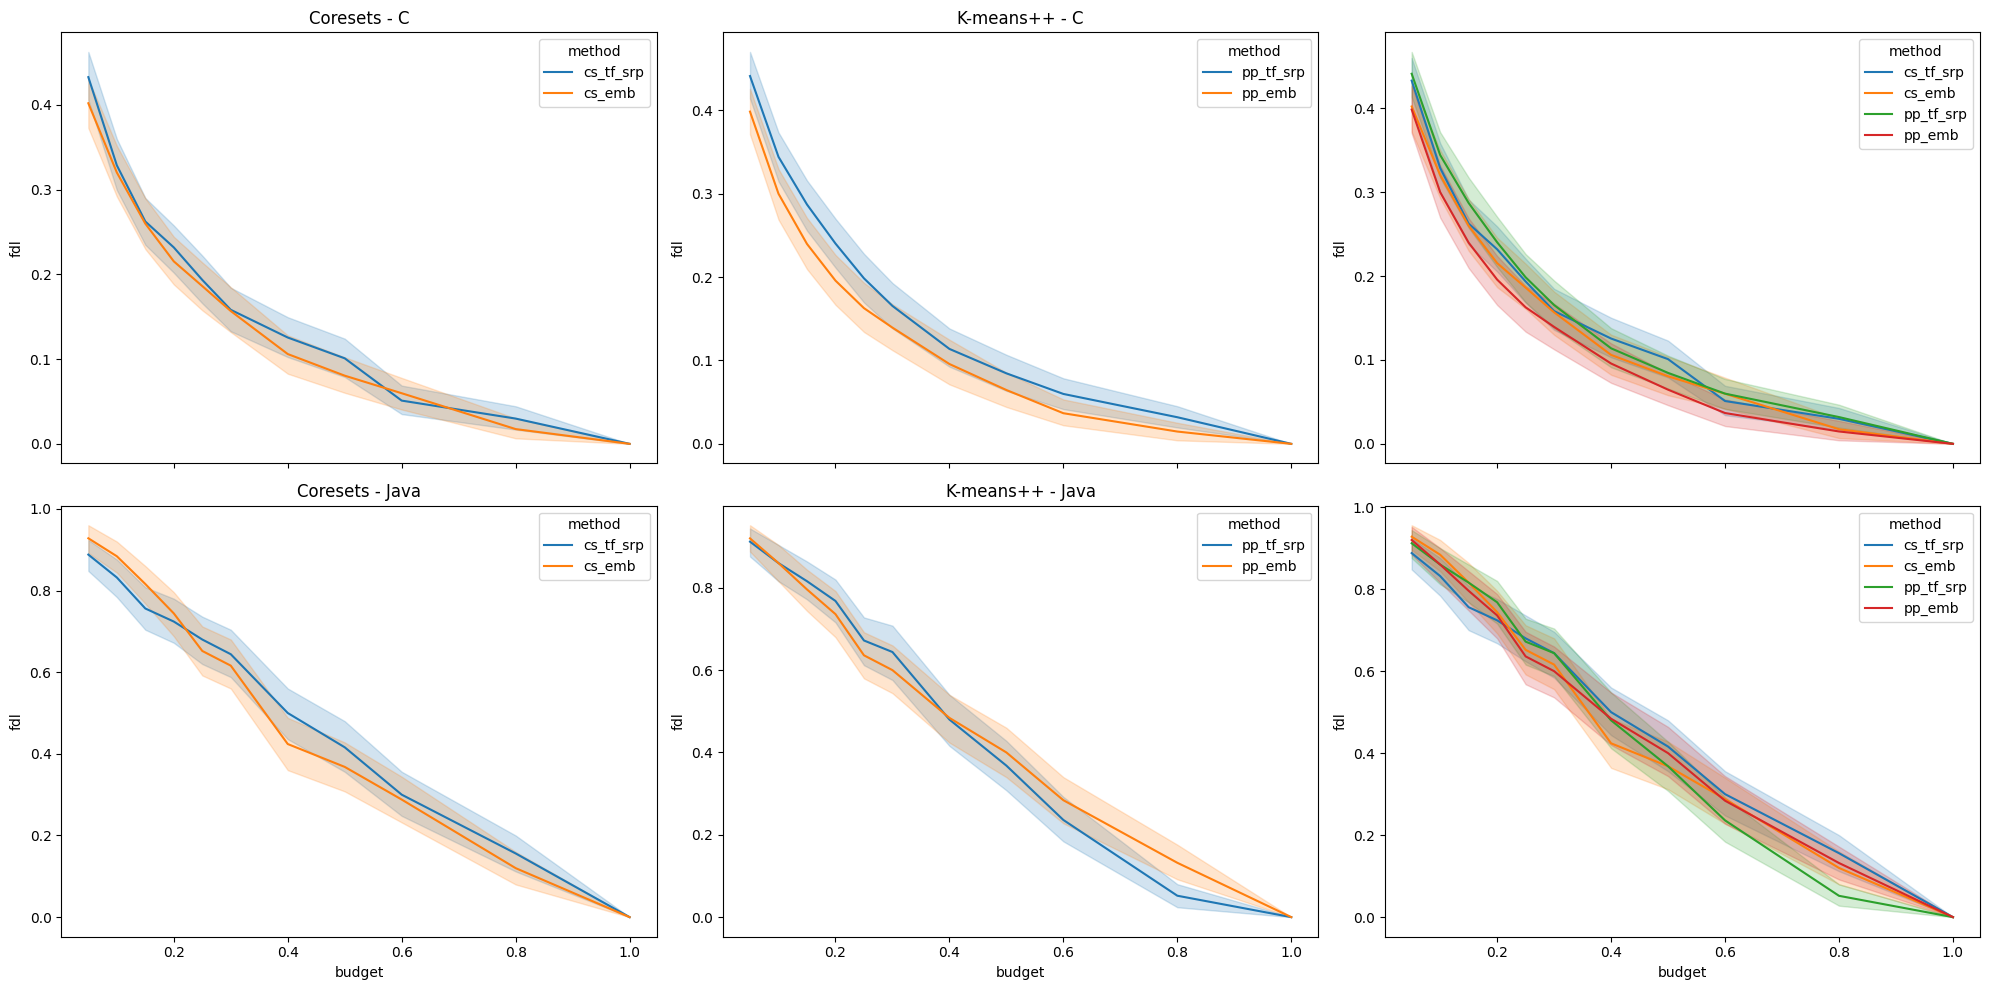

In [22]:
plot_by_algorithm_family_and_language(df_raw[df_raw['algorithm_family'] != 'random'], "mean")

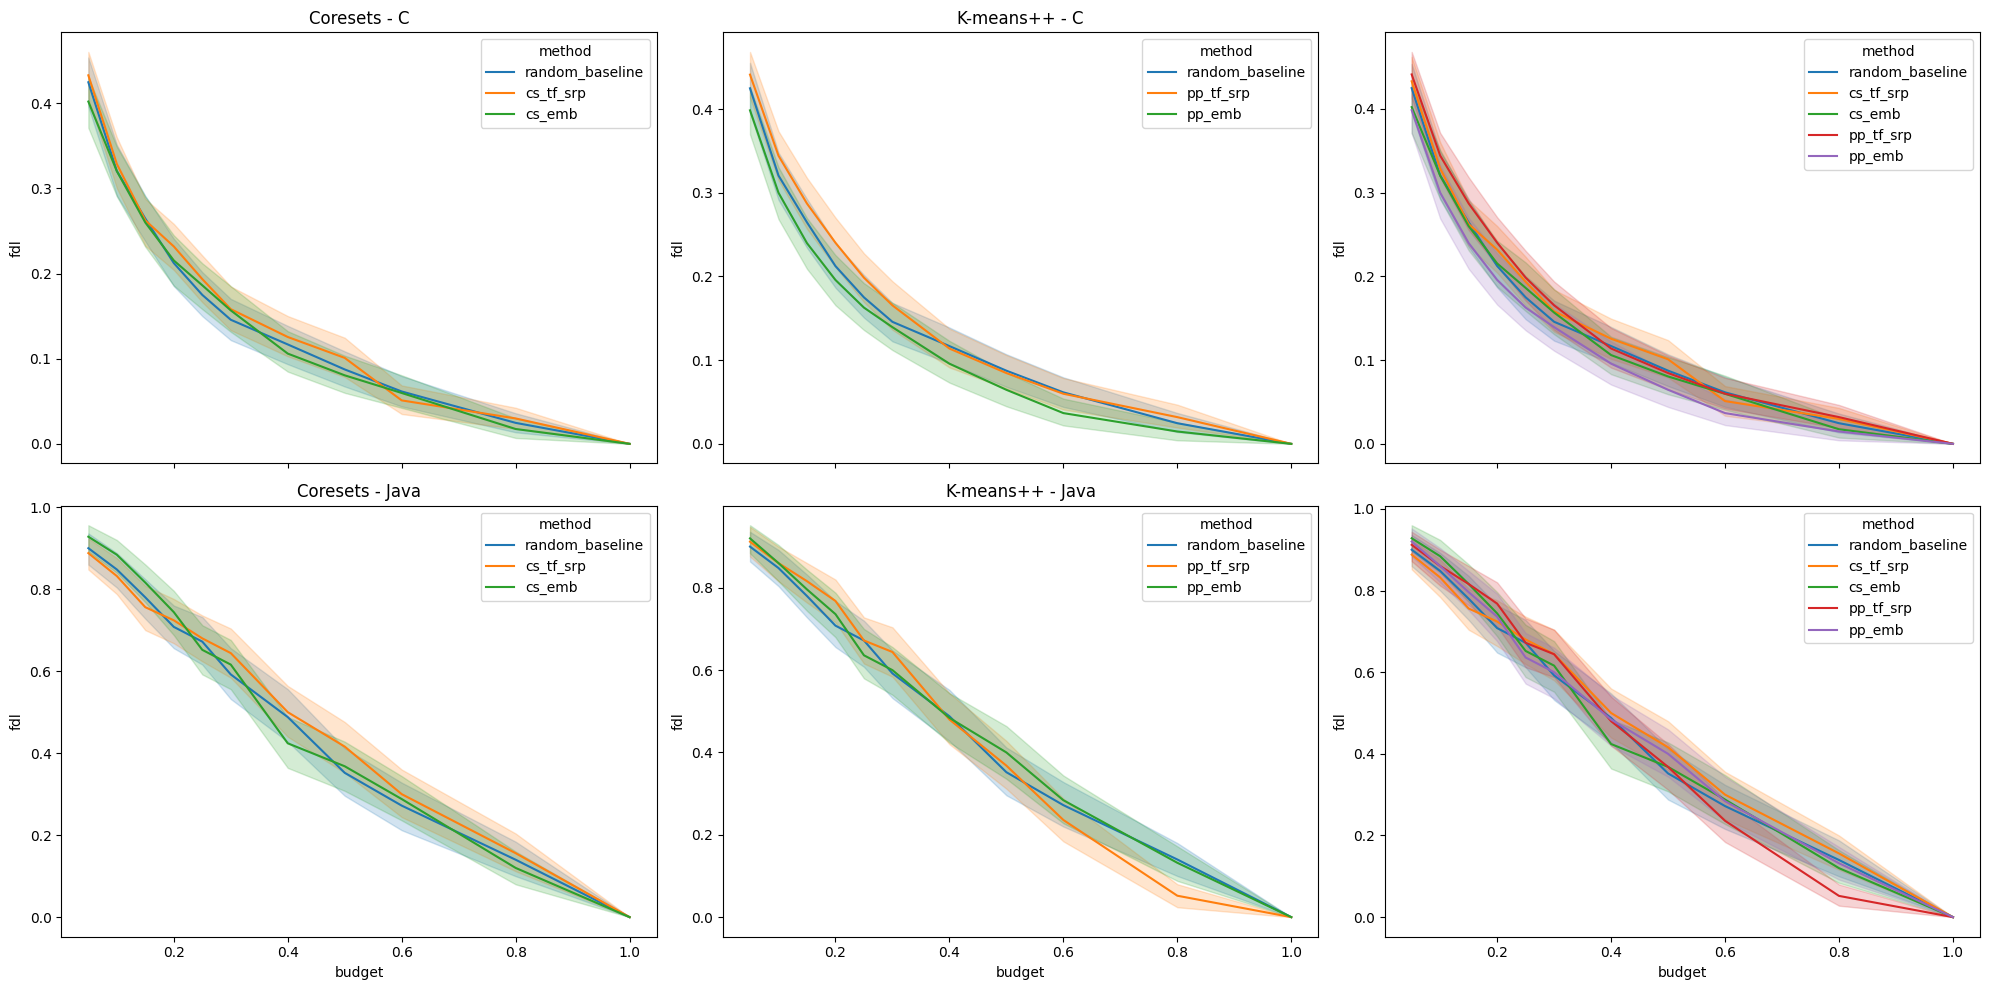

In [23]:
plot_by_algorithm_family_and_language(df_raw, "mean")

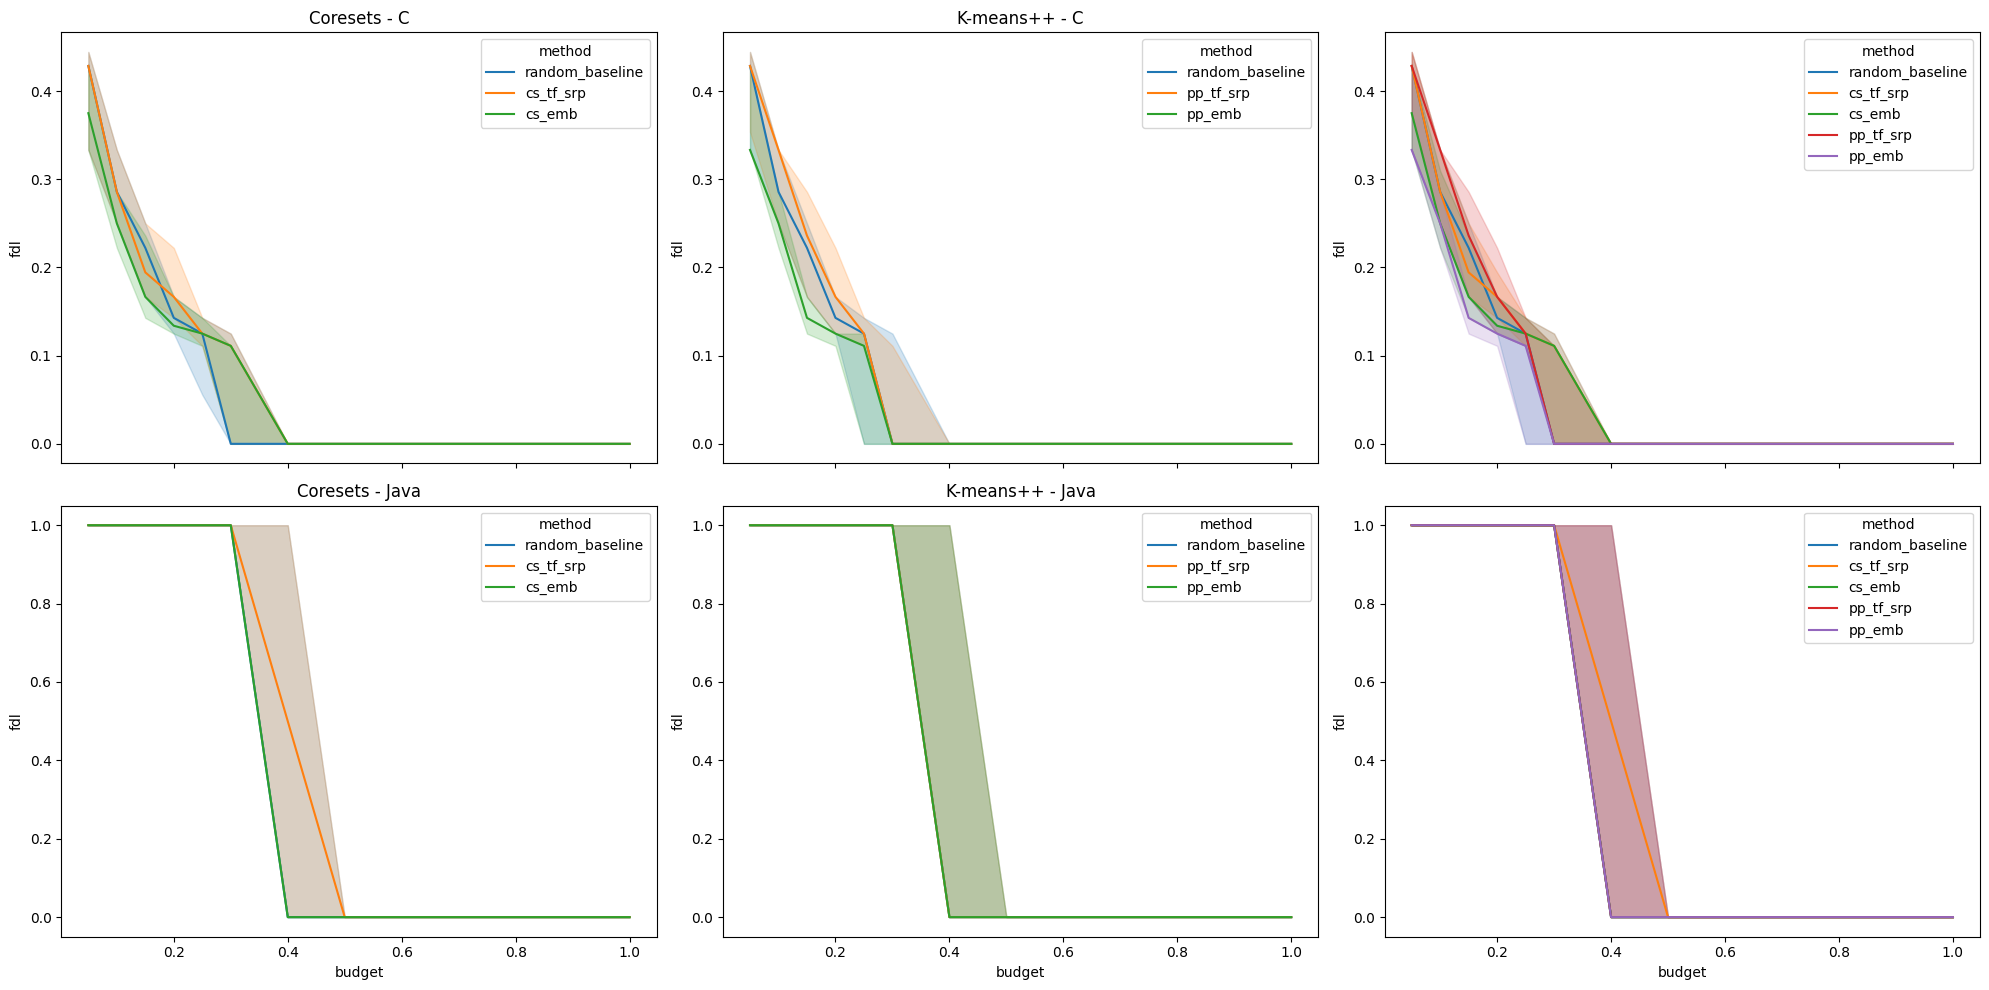

In [20]:
plot_by_algorithm_family_and_language(df_raw, "median")

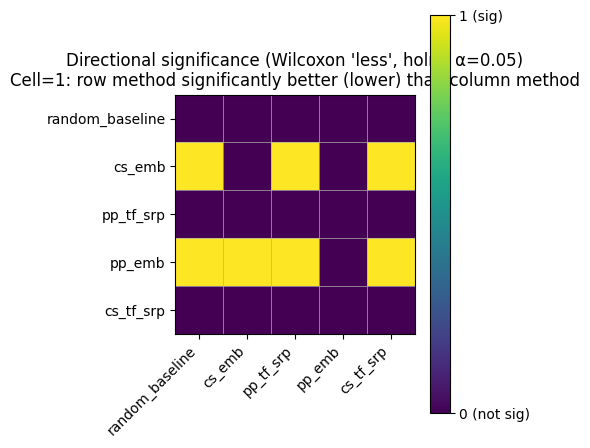

In [44]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

alpha = 0.05
mt_method = "holm"  # "fdr_bh", "bonferroni", ...

methods = df['method'].unique()

pivot_df = pivot_df_C[methods].copy()

# Optional: order methods by median performance (lower is better)
order = pivot_df.median(axis=0, skipna=True).sort_values(ascending=True).index.tolist()

# --- 1) Directional pairwise tests: cell (i,j)=1 means i significantly BETTER (lower) than j ---
pvals = []
pairs = []

for m1, m2 in itertools.permutations(methods, 2):
    x, y = pivot_df[m1], pivot_df[m2]
    mask = x.notna() & y.notna()
    x2, y2 = x[mask], y[mask]
    if len(x2) == 0:
        continue

    # Lower is better => test m1 < m2
    res = wilcoxon(x2, y2, alternative="less")
    pairs.append((m1, m2))
    pvals.append(res.pvalue)

p_adj = multipletests(pvals, method=mt_method)[1]

better = pd.DataFrame(0, index=methods, columns=methods, dtype=int)
for (m1, m2), pa in zip(pairs, p_adj):
    if pa < alpha:
        better.loc[m1, m2] = 1

np.fill_diagonal(better.values, 0)

# Reorder for readability
better = better.loc[order, order]

# --- 2) Heatmap (binary, directional) ---
fig, ax = plt.subplots(figsize=(0.6*len(order) + 2, 0.6*len(order) + 2))
im = ax.imshow(better.values, vmin=0, vmax=1, interpolation="nearest")

ax.set_xticks(np.arange(len(order)))
ax.set_yticks(np.arange(len(order)))
ax.set_xticklabels(order, rotation=45, ha="right")
ax.set_yticklabels(order)

ax.set_title(f"Directional significance (Wilcoxon 'less', {mt_method}, α={alpha})\n"
             "Cell=1: row method significantly better (lower) than column method")
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(["0 (not sig)", "1 (sig)"])

# draw grid lines for readability
ax.set_xticks(np.arange(-0.5, len(order), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(order), 1), minor=True)
ax.grid(which="minor", linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
plt.show()


In [48]:
import numpy as np
import pandas as pd
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

df = df_raw.copy()

# --- categorical factors ---
cat_cols = ["program","language","algorithm_family","representation",
            "budget_prop_requested","random_seed"]
for c in cat_cols:
    df[c] = df[c].astype("category")

# --- binomial pieces ---
df["y"] = pd.to_numeric(df["faults_detected"], errors="coerce").astype("Int64")
df["n"] = pd.to_numeric(df["total_faults"], errors="coerce").astype("Int64")
df = df.dropna(subset=["y","n"]).copy()
df = df[(df["n"] > 0) & (df["y"] >= 0) & (df["y"] <= df["n"])].copy()

# Replication-unit id (preserves pairing within program-budget-seed)
df["unit"] = (
    df["program"].astype(str)
    + "|b=" + df["budget_prop_requested"].astype(str)
    + "|s=" + df["random_seed"].astype(str)
).astype("category")

# --- EXPAND to Bernoulli trials: one row per fault (detected=1/0) ---
n = df["n"].to_numpy(dtype=int)
y = df["y"].to_numpy(dtype=int)

N = int(n.sum())
print(f"Expanding to {N:,} Bernoulli observations")

idx = np.repeat(np.arange(len(df)), n)
df_long = df.iloc[idx].copy()

print(f"Done expanding to {N:,} Bernoulli observations")

# Create binary endog vector: within each original row block, first y entries are 1
starts = np.cumsum(np.r_[0, n[:-1]])
endog = np.zeros(N, dtype=int)
for s, yi in zip(starts, y):
    if yi:
        endog[s:s+yi] = 1

df_long["detected"] = endog

# --- Mixed model (Bernoulli GLMM) ---
formula = "detected ~ algorithm_family * representation * budget_prop_requested + language"
vc_formulas = {
    "program": "0 + C(program)",
    "unit": "0 + C(unit)",
}

model = BinomialBayesMixedGLM.from_formula(formula, vc_formulas, data=df_long)
res = model.fit_vb()
print(res.summary())


Expanding to 148,500 Bernoulli observations
Done expanding to 148,500 Bernoulli observations


KeyboardInterrupt: 

In [ ]:
import patsy
import pandas as pd
import numpy as np

# --- Build a prediction grid (all combinations you care about) ---
grid = pd.MultiIndex.from_product(
    [
        df["budget_prop_requested"].cat.categories,
        df["language"].cat.categories,
        df["algorithm_family"].cat.categories,
        df["representation"].cat.categories,
    ],
    names=["budget_prop_requested", "language", "algorithm_family", "representation"],
).to_frame(index=False)

# Ensure categorical dtypes match training data
for c in ["budget_prop_requested", "language", "algorithm_family", "representation"]:
    grid[c] = pd.Categorical(grid[c], categories=df[c].cat.categories)

# --- Fixed-effects design matrix for the RHS of your formula ---
rhs = formula.split("~", 1)[1]
Xg = patsy.dmatrix(rhs, grid, return_type="dataframe")

# --- Predicted p using fixed effects only ---
# VB result stores fixed-effect means in res.fe_mean
eta = np.asarray(Xg @ res.fe_mean)
grid["p_hat"] = 1.0 / (1.0 + np.exp(-eta))
grid["fdl_hat"] = 1.0 - grid["p_hat"]

# --- Helper to compute contrasts within each (budget, language) ---
# Assumes exactly 2 algorithm families and 2 representations
alg_levels = list(df["algorithm_family"].cat.categories)
rep_levels = list(df["representation"].cat.categories)

if len(alg_levels) != 2 or len(rep_levels) != 2:
    raise ValueError(f"Expected 2 algorithm_family and 2 representation levels, got {alg_levels=} {rep_levels=}")

A0, A1 = alg_levels  # baseline and other (coding impacts coefficient names, not these contrasts)
R0, R1 = rep_levels

def pivot_preds(g):
    p = g.pivot_table(
        index=["budget_prop_requested", "language"],
        columns=["algorithm_family", "representation"],
        values="p_hat",
        aggfunc="first",
    )
    # Simple effects (method difference) at each representation
    p[("method_diff_at_" + str(R0), "")] = p[(A1, R0)] - p[(A0, R0)]
    p[("method_diff_at_" + str(R1), "")] = p[(A1, R1)] - p[(A0, R1)]
    # Interaction: (A1-A0 at R1) - (A1-A0 at R0)
    p[("interaction", "")] = p[("method_diff_at_" + str(R1), "")] - p[("method_diff_at_" + str(R0), "")]
    # Same contrasts on FDL scale (note sign flip vs p)
    # fdl = 1 - p, so diffs are -(diffs in p)
    p[("fdl_method_diff_at_" + str(R0), "")] = -p[("method_diff_at_" + str(R0), "")]
    p[("fdl_method_diff_at_" + str(R1), "")] = -p[("method_diff_at_" + str(R1), "")]
    p[("fdl_interaction", "")] = -p[("interaction", "")]
    return p

contrasts = pivot_preds(grid).reset_index()
# flatten column names
contrasts.columns = [
    c if isinstance(c, str) else (c[0] if c[1] == "" else f"{c[0]}_{c[1]}")
    for c in contrasts.columns
]

# Keep the most interpretable columns
keep_cols = [
    "budget_prop_requested", "language",
    f"method_diff_at_{R0}", f"method_diff_at_{R1}", "interaction",
    f"fdl_method_diff_at_{R0}", f"fdl_method_diff_at_{R1}", "fdl_interaction",
]
print(contrasts[keep_cols].head(10))
